In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np


In [4]:
dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl')
# dataset = pd.read_pickle('../../../geodata/results/01_master_building_dataset.pkl')

maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)



In [5]:
import joblib
xgb_model   = joblib.load("../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
# xgb_model   = joblib.load("../../../geodata/results/t10agglo_models/tr292ts73_XGB.joblib")
model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

scaler_4model   = joblib.load("../../geodata/results/scaler_for_model.joblib")
# scaler_4model   = joblib.load("../../../geodata/results/scaler_for_model.joblib")

X = dataset.copy()
X[model_feats] = scaler_4model.transform(dataset[model_feats])

X['XGB'] = xgb_model.predict(X[xgb_model.feature_names_in_])
X = X.reset_index()


In [6]:
ch_hexbin = gpd.read_file('../../geodata/ch_terrain/ch_slope_2056.gpkg').reset_index()
# ch_hexbin = gpd.read_file('../../../geodata/ch_terrain/ch_slope_2056.gpkg').reset_index()
ch_hexbin.rename(columns = {'index':'hexbin_id','_median':'slope_median', '_mean':'slope_mean'}, inplace = True)
ch_hexbin.plot('slope_mean', edgecolor = 'none')

In [ ]:
%time X = gpd.sjoin(ch_hexbin[['hexbin_id', 'slope_mean','slope_median','geometry']],X,how='right')

In [8]:
#get average neighbor value
%time buffered = X.buffer(100, cap_style=3)
%time buff_idx, pt_idx = X.geometry.sindex.query_bulk(buffered, predicate="contains")
%time latent = np.take(X[['slope_median','slope_mean','XGB']], pt_idx, axis=0)
%time group = pd.DataFrame(latent).groupby(buff_idx)
%time nabr = group.mean()
X['avg_slope'] = nabr.slope_mean
X['med_slope'] = nabr.slope_median
X['avg_nabr_pred'] = nabr.XGB
X['num_nabr'] = group.size()

CPU times: total: 32.6 s
Wall time: 32.6 s


In [3]:
# X.to_pickle('../../../geodata/results/03_spatial_lagged_master.pkl')
X = pd.read_pickle('../../geodata/results/02_spatial_lagged_master.pkl')

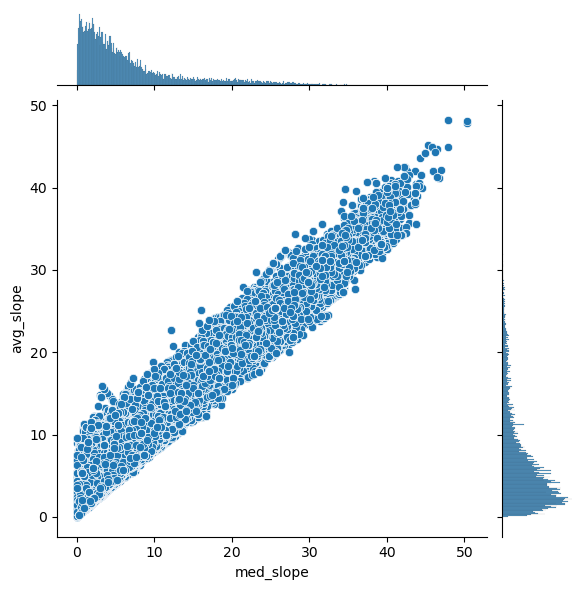

In [4]:
import seaborn as sns

sns.jointplot(x='med_slope', y='avg_slope', data=X)